# Final Report

# Inference of median house prices of districts in California based on house and district characteristics

By group 4 - Tianne Lee, Sid Ahuja, William Ho, Weihao Sun

## Introduction

The housing market is dependent on several microeconomic and macroeconomic variables. Individual house prices are often reflective of the spatial and socioeconomic characteristics of the neighborhood in which the house resides (Stadelmann, 2010). While generating a regression model may be a robust technique to make estimates and inferences regarding house prices, many aspects of spatial elements need to be taken into consideration before doing so (Kelley Pace & Barry, 1997). Using a housing dataset, we want to explore which qualities and characteristics of houses within a district are best to include in a regression model, helping us understand the relationship between house prices and the determined set of input variables for the population. To create a better understanding towards the topic, we ask the following question: 

What combination of house and district qualities best estimate their relationship to the median house prices in a district and are those qualities significantly associated with the median house price of the district? 

In order to explore this question and the relation between median housing prices and different qualities of houses in a district, we will be using a [modified version of the California Housing dataset](https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv). This dataset is about houses found in given California block groups based on the 1990 census data. Each observation in the dataset corresponds to a block group, the smallest geographical unit for which the U.S. Census Bureau publishes sample data (Géron, 2017). In our project, we will use the words “block group” and “district” interchangeably.

The qualities (explanatory variables) that we would like to explore include:

|Attribute|Variable|Description|
|:---:|:---:|:---:|
|Continuous|Longitude|Longitude of the district|
|Continuous|Latitude|Latitude of the district|
|Continuous|Housing_median_age|Median housing age of the district|
|Continuous|Total_rooms|Total rooms in the district|
|Continuous|Total_bedrooms|Total bedrooms in the district|
|Continuous|Population|Total population in the district|
|Continuous|Households|Total households in the district|
|Continuous|Median_income|Median income of the district|
|Categorical|Ocean_proximity|Distance to the ocean, with categories: <br /> <1H OCEAN, INLAND, NEAR OCEAN, NEAR BAY, ISLAND|

## Methods and Results

In [1]:
library(tidyverse)
library(dplyr)
library(glmnet)
library(car)
library(broom)
library(leaps)

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.6     v dplyr   1.0.8
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Loaded glmnet 4.1-6

Loading required package: carData


Attaching package: 'car'


The following object is masked from 'package:dplyr':

    recode


The following object is masked from 'package:purrr':

    some




## Data loading and preprocessing

In [3]:
data <- read_csv("house_data.csv", show_col_types = FALSE) %>% drop_na()

New names:
* `` -> ...1



In [4]:
# preprocessing from the proposal

data <- data %>% mutate(rooms_per_household = total_rooms / households,
                       bedrooms_per_household = total_bedrooms / households,
                       population_per_household = population / households) %>%
                select(-...1)
data <- data %>% relocate(median_house_value, .after = last_col())

head(data)

longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_household,population_per_household,median_house_value
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
-122.23,37.88,41,880,129,322,126,8.3252,NEAR BAY,6.984127,1.0238095,2.555556,452600
-122.22,37.86,21,7099,1106,2401,1138,8.3014,NEAR BAY,6.238137,0.9718805,2.109842,358500
-122.24,37.85,52,1467,190,496,177,7.2574,NEAR BAY,8.288136,1.0734463,2.802260,352100
-122.25,37.85,52,1274,235,558,219,5.6431,NEAR BAY,5.817352,1.0730594,2.547945,341300
-122.25,37.85,52,1627,280,565,259,3.8462,NEAR BAY,6.281853,1.0810811,2.181467,342200
-122.25,37.85,52,919,213,413,193,4.0368,NEAR BAY,4.761658,1.1036269,2.139896,269700


## Fitting a full linear model and dropping highly correlated columns

In [5]:
full_model <- lm(median_house_value~., data = data)
tidy(full_model)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-2.355682e+06,8.861237e+04,-26.584116,4.159506e-153
longitude,-2.766339e+04,1.026361e+03,-26.952876,2.962510e-157
latitude,-2.635291e+04,1.014102e+03,-25.986448,1.690167e-146
housing_median_age,1.073456e+03,4.379668e+01,24.509976,8.946624e-131
total_rooms,-3.589039e+00,9.357749e-01,-3.835366,1.257542e-04
total_bedrooms,5.946919e+01,7.890935e+00,7.536394,5.032696e-14
population,-3.887653e+01,1.107548e+00,-35.101428,3.817785e-262
households,8.275246e+01,8.310903e+00,9.957096,2.653919e-23
median_income,4.033897e+04,4.128793e+02,97.701587,0.000000e+00


We then check for multicolinearity and drop columns that are highly correlated.

In [6]:
vif(full_model)

,GVIF,Df,GVIF^(1/(2*Df))
longitude,18.427132,1,4.292684
latitude,20.452759,1,4.522473
housing_median_age,1.325266,1,1.151202
total_rooms,18.222064,1,4.268731
total_bedrooms,48.179240,1,6.941127
population,6.864198,1,2.619961
households,43.989398,1,6.632450
median_income,2.679626,1,1.636956
ocean_proximity,4.173184,4,1.195524
rooms_per_household,12.356066,1,3.515120


As seen in the graph, `longitude`, `latitude`, `total_rooms`, `total_bedrooms`, and `households` has the highest GVIF value. We will drop these columns.

In [7]:
data  <- data %>% select(-longitude, -latitude, -total_rooms, -total_bedrooms, -households)

In [8]:
full_2  <- lm(median_house_value~., data = data)
vif(full_2)

,GVIF,Df,GVIF^(1/(2*Df))
housing_median_age,1.284132,1,1.133196
population,1.131283,1,1.063618
median_income,2.531770,1,1.591154
ocean_proximity,1.399761,4,1.042934
rooms_per_household,8.483032,1,2.912564
bedrooms_per_household,7.223765,1,2.687706
population_per_household,1.008783,1,1.004382


With low multicolinearity (GVIF < 10) in our columns, we are now ready to train inference models on our data.

## Creating generative models

To avoid bias, we will first split our data into two evenly divided portions -- one for variable selection, and the other for fitting the inference model. We will name the two portions `data_selection` and `data_inference`.

In [17]:
set.seed(1234)
indices <- sample.int(nrow(data), nrow(data) / 2)
data_selection <- data[indices, ]
data_inference <- data[-indices, ]

### Using stepwise algorithms to select a generative model

Rather than arbitrarily using the full model, we would like to select particular variables to form a better model. In this section, automated procedures will be conducted to select the best model. The two most common methods will be used, which are Forward and Backward algorithms.

First, we will use Forward selection. We will use the dataset `data_selection` to perform the selection algorithm. A summary of the Forward selection result is generated as follows.

In [18]:
housing_forward_sel <- regsubsets(
    x = median_house_value ~ ., nvmax=10,
    data = data_selection, 
    method = "forward")
housing_forward_summary <- summary(housing_forward_sel)
housing_forward_summary$which

,(Intercept),housing_median_age,population,median_income,ocean_proximityINLAND,ocean_proximityISLAND,ocean_proximityNEAR BAY,ocean_proximityNEAR OCEAN,rooms_per_household,bedrooms_per_household,population_per_household
1,TRUE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
2,TRUE,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
3,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
4,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE
5,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE
6,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,FALSE,FALSE
7,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE
8,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE
9,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
10,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE


To have a more intuitive result, as well as obtain the corresponding statistics of each number of selected variables, a summary table is generated, which is useful to decide the number of variables in the best model. For the generative model, we will refer to adjusted $R^2$. To be specific, the `n_input_variables` with the largest adjusted $R^2$ value will be selected. A plot is also generated for a better view and understanding.

In [19]:
housing_forward_summary_df <- tibble(
    n_input_variables = 1:10,
    RSQ = housing_forward_summary$rsq,
    RSS = housing_forward_summary$rss,
    ADJR2 = housing_forward_summary$adjr2,
    Cp = housing_forward_summary$cp,
    BIC = housing_forward_summary$bic)
housing_forward_summary_df

n_input_variables,RSQ,RSS,ADJR2,Cp,BIC
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.4721471,7.055552e+13,0.4720955,3494.083715,-6508.924
2,0.5843054,5.556388e+13,0.5842240,583.813754,-8939.954
3,0.5949812,5.413689e+13,0.5948622,308.608080,-9196.516
4,0.5969492,5.387384e+13,0.5967913,259.507824,-9237.045
5,0.5991641,5.357779e+13,0.5989678,203.996391,-9284.109
6,0.5997672,5.349717e+13,0.5995320,190.335920,-9290.260
7,0.6003454,5.341988e+13,0.6000714,177.321274,-9295.799
8,0.6065615,5.258902e+13,0.6062531,17.918042,-9446.710
9,0.6069534,5.253663e+13,0.6066068,9.742126,-9447.659


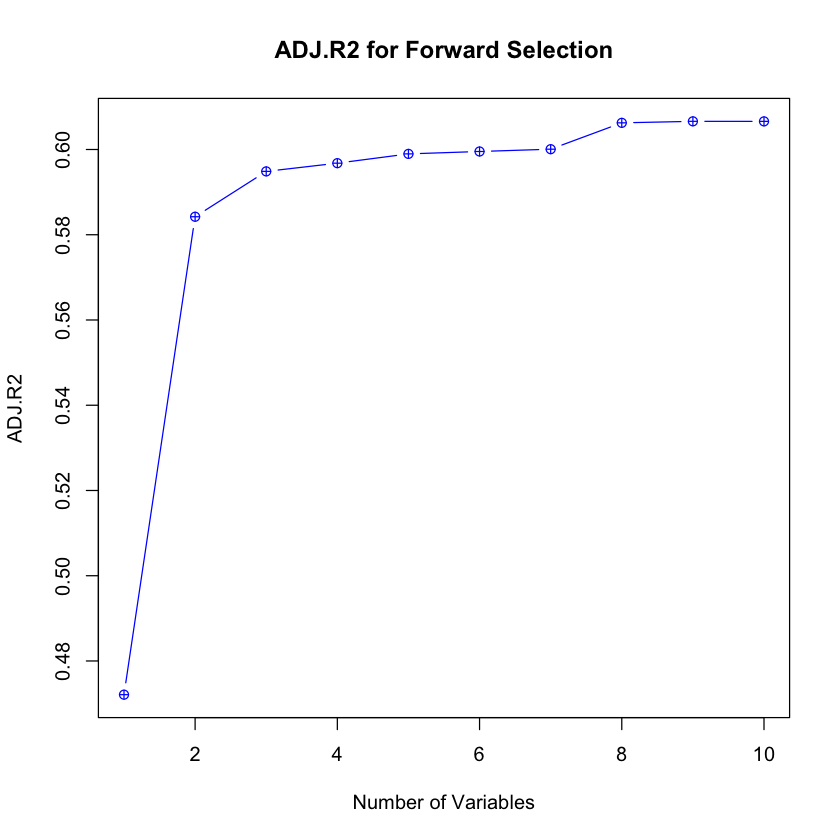

In [20]:
plot(summary(housing_forward_sel)$adjr2,
    main = "ADJ.R2 for Forward Selection", xlab = "Number of Variables", ylab="ADJ.R2",
    type = "b", pch = 10, col="blue")

As the results show, the best model contains 9 variables based on Forward selection. In this model, all of the variable are used. The corresponding adjusted $R^2$ value is 0.6066, which is the largest among all the possible $n$.

To ensure the correctness and validation of our selection, the Backward Algorithm will also be performed. We will still use the dataset `data_selection`. The summary of the selection as well as the table with all the possible number of variables and the corresponding statistics will be generated.

In [21]:
housing_backward_sel <- regsubsets(
    x = median_house_value ~ ., nvmax=10,
    data = data_selection, 
    method="backward",
)
housing_backward_summary <- summary(housing_backward_sel)
housing_backward_summary$which

,(Intercept),housing_median_age,population,median_income,ocean_proximityINLAND,ocean_proximityISLAND,ocean_proximityNEAR BAY,ocean_proximityNEAR OCEAN,rooms_per_household,bedrooms_per_household,population_per_household
1,TRUE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
2,TRUE,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
3,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
4,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE
5,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,TRUE,TRUE,FALSE
6,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE,TRUE,TRUE,TRUE,FALSE
7,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,FALSE
8,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE
9,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
10,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE


In [22]:
housing_backward_summary_df <- tibble(
    n_input_variables = 1:10,
    RSQ = housing_backward_summary$rsq,
    RSS = housing_backward_summary$rss,
    ADJR2 = housing_backward_summary$adjr2,
    Cp = housing_backward_summary$cp,
    BIC = housing_backward_summary$bic)
housing_backward_summary_df

n_input_variables,RSQ,RSS,ADJR2,Cp,BIC
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.4721471,7.055552e+13,0.4720955,3494.083715,-6508.924
2,0.5843054,5.556388e+13,0.5842240,583.813754,-8939.954
3,0.5949812,5.413689e+13,0.5948622,308.608080,-9196.516
4,0.5956269,5.405058e+13,0.5954685,293.841366,-9203.585
5,0.6015860,5.325406e+13,0.6013909,141.109564,-9346.023
6,0.6035919,5.298595e+13,0.6033589,91.025501,-9388.355
7,0.6060368,5.265915e+13,0.6057666,29.542012,-9442.327
8,0.6065615,5.258902e+13,0.6062531,17.918042,-9446.710
9,0.6069534,5.253663e+13,0.6066068,9.742126,-9447.659


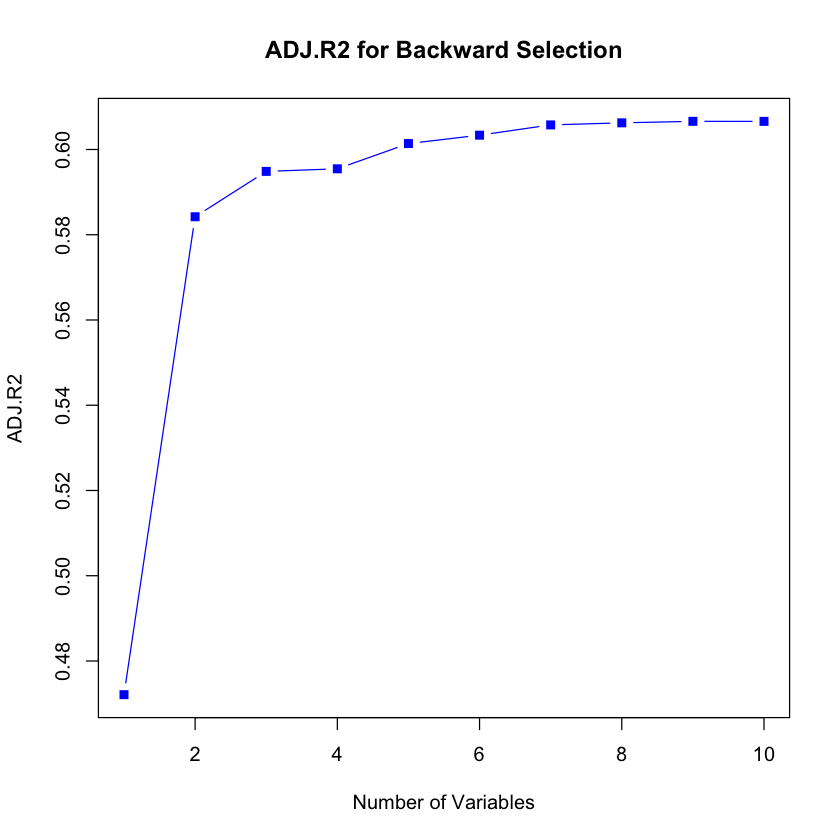

In [23]:
plot(summary(housing_backward_sel)$adjr2,
    main = "ADJ.R2 for Backward Selection", xlab = "Number of Variables", ylab="ADJ.R2",
    type = "b", pch = 15, col="blue")

From the results above, it is clear that the number of selective variables is also 9, with the same adjusted $R^2$, 0.60. The selected model is also the one with all the variables except `population`. With that being said, our final stepwise model will contain the following explanatory variables: `housing_median_age`,	`median_income`, `ocean_proximity`, `rooms_per_household`, `bedrooms_per_household`, and `population_per_household`.

### Using LASSO to select a generative model

Other than using forward/backward selection to create a model, we would like to see if LASSO generates a model with different parameters. Simutaneously, we would like to explore whether LASSO yields a better or worse performing model. 

We will choose our LASSO with a $\lambda$ value that gives the smallest $MSE_{test}$.

In the following cell, we create the X and Y portion of the variable selection portion. Because we have a categorical variable, `ocean_promixity`, we need to create group dummy variables in order to fit a LASSO model. The code to do so is referenced [here](https://stackoverflow.com/questions/46865838/using-lasso-in-r-with-categorical-variables). 

In [27]:
set.seed(1234)

data_selection <- data_selection %>% mutate(ocean_proximity = as.factor(ocean_proximity))
data_selection_Y <- data_selection %>% select(median_house_value) %>% as.matrix()

vars_name <- data_selection %>% 
  select(-median_house_value) %>% 
  colnames() %>%
  str_c(collapse = "+")

model_string <- paste("median_house_value  ~", vars_name)

data_selection_X <- model.matrix(as.formula(model_string), data_selection)

Then, we train the regression using LASSO and find the optimal value of the hyperparameter $\lambda$.

The best lambda value is 665.1416

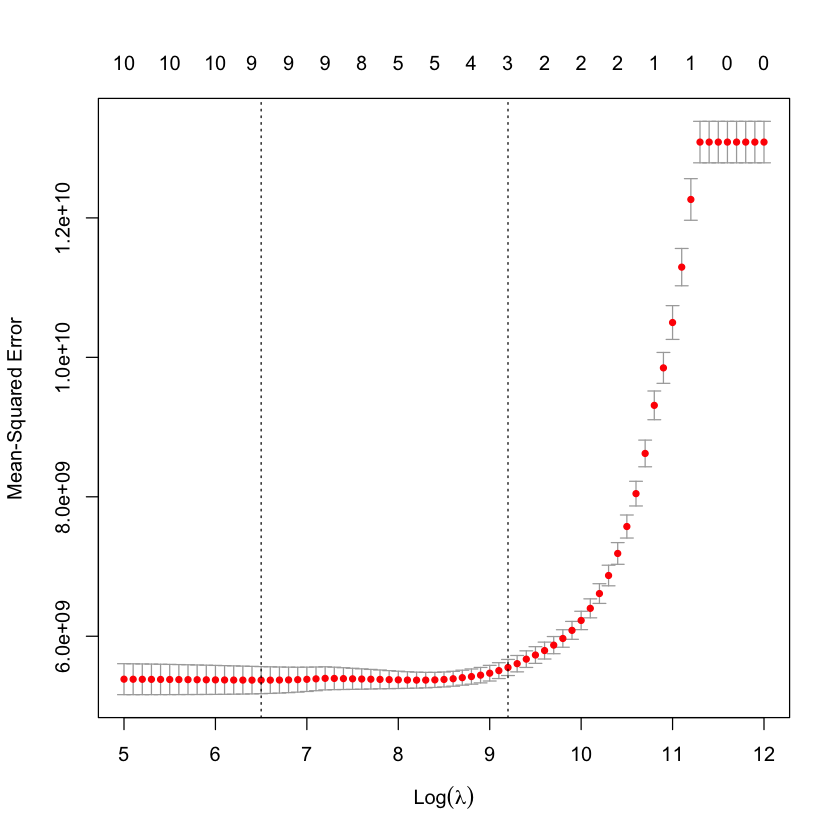

In [29]:
set.seed(1234)

# referenced from worksheet 11
housing_lambda_LASSO <- cv.glmnet(
  x = data_selection_X, y = data_selection_Y,
  alpha = 1,
  lambda = exp(seq(5, 12, 0.1))
)

housing_lambda_min_MSE_LASSO <- round(housing_lambda_LASSO$lambda.min, 4)
cat("The best lambda value is", housing_lambda_min_MSE_LASSO)
plot(housing_lambda_LASSO)

Now, we train another LASSO model using the optimal lambda we found.

In [30]:
housing_LASSO_min <- glmnet(
  x = data_selection_X, y = data_selection_Y,
  alpha = 1,
  lambda = housing_lambda_min_MSE_LASSO
)

In [31]:
housing_LASSO_min$beta

11 x 1 sparse Matrix of class "dgCMatrix"
                                   s0
(Intercept)                    .     
housing_median_age           860.9698
population                     .     
median_income              40257.3054
ocean_proximityINLAND     -67071.9226
ocean_proximityISLAND     144854.2277
ocean_proximityNEAR BAY    17165.6361
ocean_proximityNEAR OCEAN  17454.7760
rooms_per_household        -5745.1569
bedrooms_per_household     27409.4147
population_per_household    -320.3311

To our surprise, LASSO selected the exact same model as stepwise selection. The model also consists of 9 parameters, which are `housing_median_age`,	`median_income`, `ocean_proximity`, `rooms_per_household`, `bedrooms_per_household`, and `population_per_household`. LASSO also did not select `population` as a parameter.